In [20]:
# Import statements
import os
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
image = cv.imread("../maps/Lunar_LRO_LOLA_Global_LDEM_118m_Mar2014.tif",2)

(46080, 92160)
23040 46080
2000 2000
(2000, 2000)


True

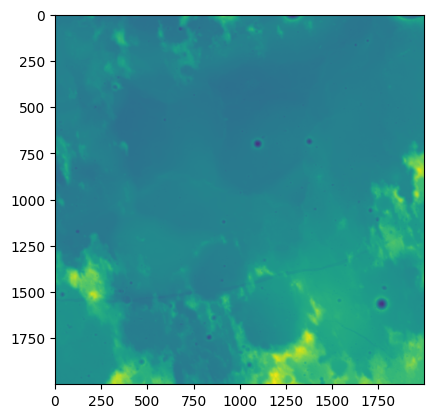

In [25]:
# Prep small section
print(image.shape)
center = np.array(image.shape,dtype=int)//2
print(center[0],center[1])
section_size = np.array([2000,2000],dtype=int)
print(section_size[0],section_size[1])
small_section = image[center[0]-section_size[0]//2:center[0]+section_size[0]//2,
											center[1]-section_size[1]//2:center[1]+section_size[1]//2]
print(small_section.shape)
plt.imshow(small_section)
cv.imwrite("interp_test.png",small_section)

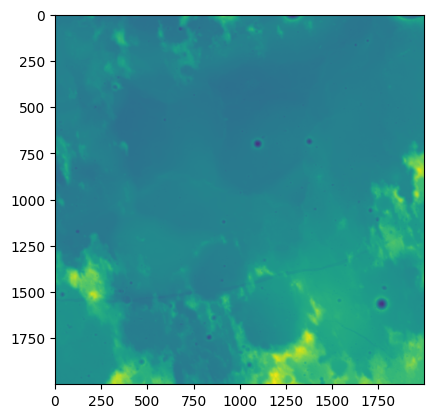

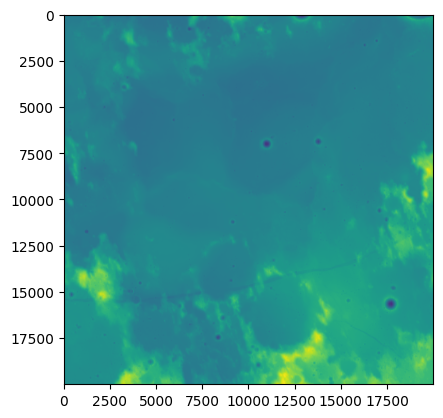

In [34]:
map = small_section
map_resize = cv.resize(map,(20000,20000),interpolation=cv.INTER_CUBIC)
plt.figure()
plt.imshow(map)
plt.figure()
plt.imshow(map_resize)

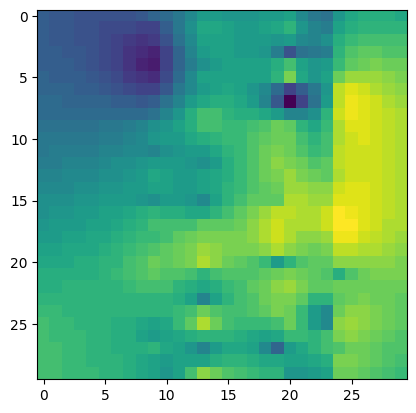

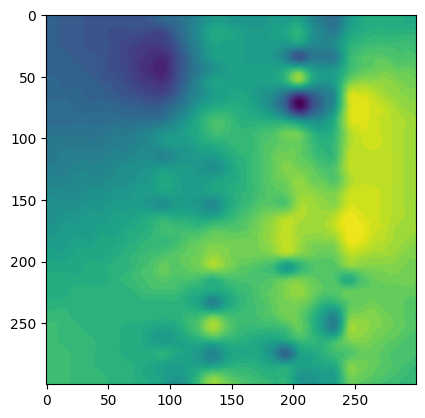

In [37]:
plt.figure()
plt.imshow(map[:30,:30])
plt.figure()
plt.imshow(map_resize[:300,:300])